# Data preparation: Step-by-Step Example
In this notebook, we walk you through the steps to preprocess and combine STEREO EUVI and SoHO EIT into a
synchronic map. This example focuses on a single channel (195 Å) and uses [sample data](https://drive.google.com/drive/folders/1WtUW-a6fZvcFKvPwtAY-wYfHLyi1hrF5?usp=sharing) provided by Michael Kirk.

_Writen by Ajay Kumar Tiwari, Benoit Tremblay & Michael Kirk_

In [1]:
# Imports
import scipy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import sunpy.map
import sunpy.sun
from sunpy.map.maputils import all_coordinates_from_map
from sunpy.coordinates import get_horizons_coord
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd
import glob
import importlib
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

# Class for histogram matching
class hamada():
    
    def __init__(self, filename='cumulative_hist.npz'):
        # Read
        npzfile = np.load(filename)
        self.cdf_eit = npzfile['cdf_eit']
        self.bin_eit = npzfile['bins_eit']
        self.cdf_euvil = npzfile['cdf_euvil']
        self.bin_euvil = npzfile['bins_euvil']
        self.nb_channels, self.nb_bins = self.bin_eit.shape
        
    # Histogram matching (Hamada et al., 2019)
    def hist_matching(self, data_eit, channel_nb):
        
        # Standardize
        log_eit = np.log10(data_eit)
        mean_log_eit = np.nanmean(log_eit)
        std_log_eit = np.nanstd(log_eit)
        norm_log_eit = (log_eit - mean_log_eit) / std_log_eit
        
        # Extract finite values
        where_mask = np.isfinite(norm_log_eit)
        mask_log_eit = norm_log_eit[where_mask]

        # Bins
        bin_eit = (self.bin_eit[channel_nb, :-1] + self.bin_eit[channel_nb, 1:]) / 2
        bin_euvil = (self.bin_euvil[channel_nb, :-1] + self.bin_euvil[channel_nb, 1:]) / 2
        
        # Histogram matching
        cdf_tmp = np.interp(mask_log_eit.flatten(), bin_eit.flatten(),
                            self.cdf_eit[channel_nb, :].flatten())
        norm_log_adjusted = np.interp(cdf_tmp, self.cdf_euvil[channel_nb, :].flatten(),
                                      bin_euvil.flatten())
        
        # Adjust data
        norm_log_eit[where_mask] = norm_log_adjusted
        data_eit_adjusted = 10.**(norm_log_eit*std_log_eit + mean_log_eit)
        
        return data_eit_adjusted

# Masking function
def mask_outside_disk(inst_map):
    # Find coordinates and radius
    hpc_coords = all_coordinates_from_map(inst_map)
    r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / inst_map.rsun_obs

    # Mask everything outside of the solar disk
    mask = ma.masked_greater_equal(r, 1)
    ma.set_fill_value(mask, np.nan)
    where_disk = np.where(mask.mask == 1)

    return where_disk

# Make histogram
def make_hist(norm_log_inst, bins_inst):

    where_mask = np.isfinite(norm_log_inst)
    arr = norm_log_inst[where_mask]
    hist, bins = np.histogram(arr, bins=bins_inst, density=True)
    width = bins[1] - bins[0]

    return hist*width

# Find sample data
path_to_files = '/home/btremblay/Documents/dir.HelioHackWeek/sampledata/'
filenames_eit = sorted(glob.glob(path_to_files+'eit_l1*'))
filenames_euvil = sorted(glob.glob(path_to_files+'*eu_L.fts'))
filenames_euvir = sorted(glob.glob(path_to_files+'*eu_R.fts'))
filenames_test_set = sorted(glob.glob(path_to_files+'EUVI_mask*'))
# Number of samples
nb_files = len(filenames_eit)

## Step 0: The Data

Let's look at the data we'll be working with. The STEREO EUVI data was wavelet enhanced to improve contrast (see Step 2),
whereas the SoHO EIT wasn't at this.

* __SoHO/EIT data at 195 Å__

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/sunpy/map/mapbase.py:290: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color='red')


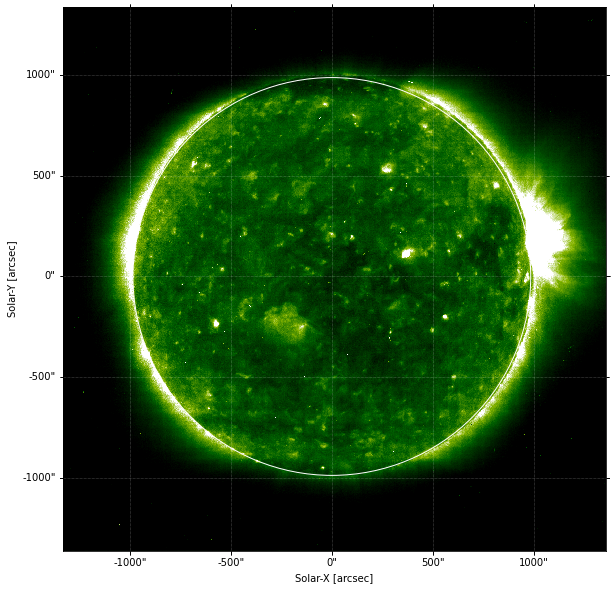

Observatory,SOHO
Instrument,EIT
Detector,EIT
Measurement,195.0 Angstrom
Wavelength,195.0 Angstrom
Observation Date,2008-01-01 00:00:09
Exposure Time,12.592000 s
Dimension,[1024. 1024.] pix
Coordinate System,helioprojective
Scale,[2.63 2.63] arcsec / pix
Reference Pixel,[506.45 516.25] pix

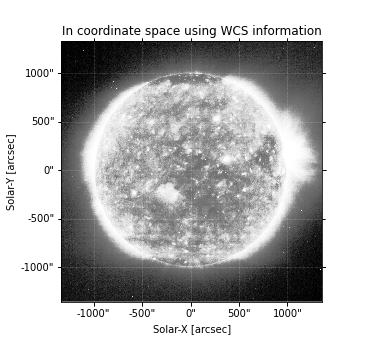
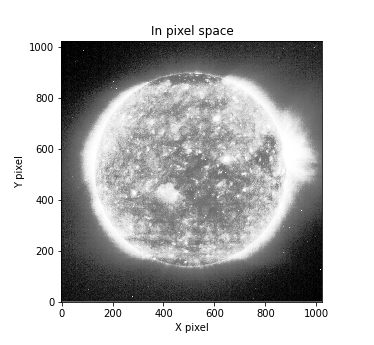
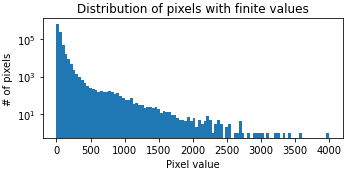

In [2]:
# Maps objects
eit_maps = sunpy.map.Map(filenames_eit)
nx_eit, ny_eit = eit_maps[0].data.shape

# Plot disk image
palette = eit_maps[0].cmap
fig = plt.figure(figsize=(10, 10))
plt.subplot(projection=eit_maps[0])
eit_maps[0].plot(cmap=palette,vmin=-1,vmax=200)
eit_maps[0].draw_limb()
plt.show()

# Properties
eit_maps[0]

* __STEREO EUVI data at 195 Å__

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/astropy/visualization/stretch.py:163: RuntimeWarning: invalid value encountered in power
  np.power(values, self.power, out=values)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/astropy/visualization/stretch.py:163: RuntimeWarning: invalid value encountered in power
  np.power(values, self

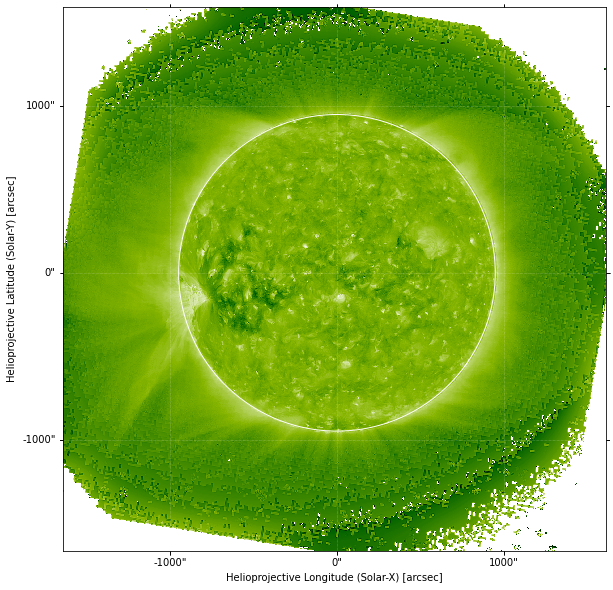

Observatory,STEREO B
Instrument,SECCHI
Detector,EUVI
Measurement,195.0 Angstrom
Wavelength,195.0 Angstrom
Observation Date,2008-01-01 00:15:52
Exposure Time,16.010800 s
Dimension,[2048. 2048.] pix
Coordinate System,helioprojective
Scale,[1.59 1.59] arcsec / pix
Reference Pixel,[1032.73 1046.83] pix

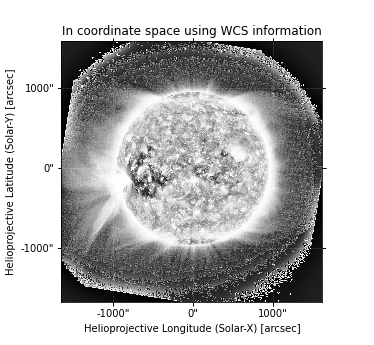
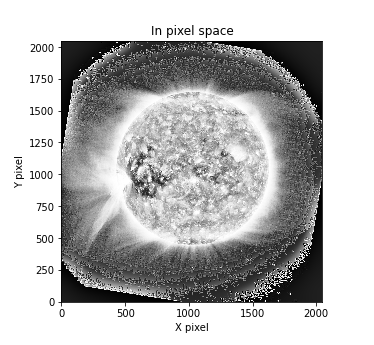
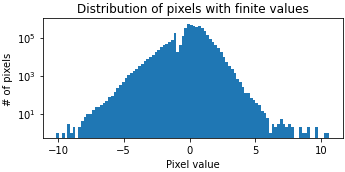

In [3]:
euvil_maps = sunpy.map.Map(filenames_euvil)
nx_euvil, ny_euvil = euvil_maps[0].data.shape

# Plot Disk Image
palette = euvil_maps[0].cmap
fig = plt.figure(figsize=(10, 10))
plt.subplot(projection=euvil_maps[0])
euvil_maps[0].plot(cmap=palette,vmin=-1,vmax=5)
euvil_maps[0].draw_limb()
plt.show()

# Properties
euvil_maps[0]

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/astropy/visualization/stretch.py:163: RuntimeWarning: invalid value encountered in power
  np.power(values, self.power, out=values)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/astropy/visualization/stretch.py:163: RuntimeWarning: invalid value encountered in power
  np.power(values, self

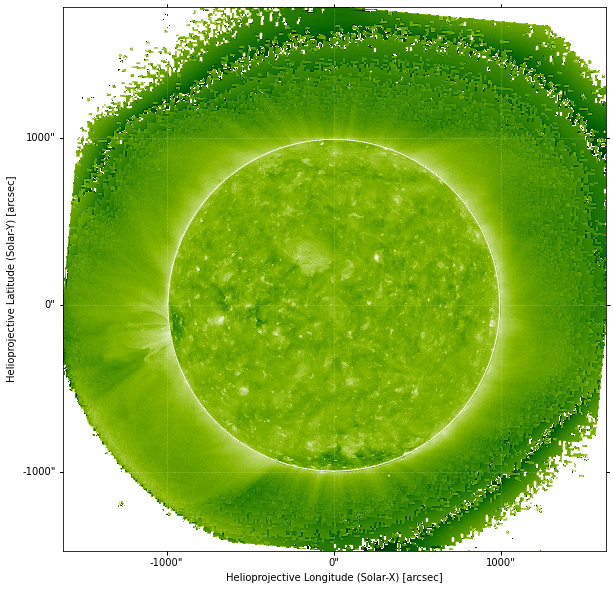

Observatory,STEREO A
Instrument,SECCHI
Detector,EUVI
Measurement,195.0 Angstrom
Wavelength,195.0 Angstrom
Observation Date,2008-01-01 00:05:30
Exposure Time,16.007400 s
Dimension,[2048. 2048.] pix
Coordinate System,helioprojective
Scale,[1.587774 1.587774] arcsec / pix
Reference Pixel,[1020.81 924.754] pix

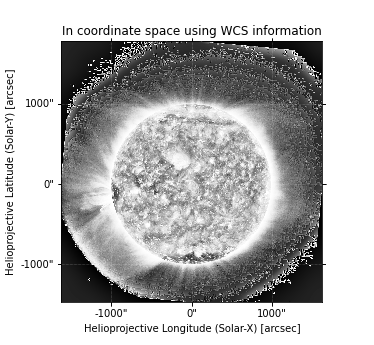
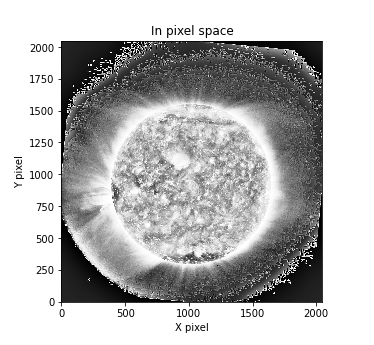
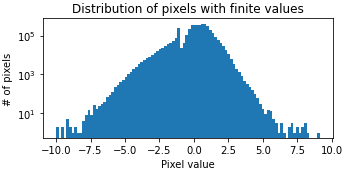

In [4]:
euvir_maps = sunpy.map.Map(filenames_euvir)
nx_euvir, ny_euvir = euvir_maps[0].data.shape

# Plot Disk Image
palette = euvir_maps[0].cmap
fig = plt.figure(figsize=(10, 10))
plt.subplot(projection=euvir_maps[0])
euvir_maps[0].plot(cmap=palette,vmin=-1,vmax=5)
euvir_maps[0].draw_limb()
plt.show()

# Properties
euvir_maps[0]


## Step 1: Masking Everything Outside of the Solar Disk

Self-explanatory.

* __SoHO EIT Data at 195 Å__

INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/sunpy/map/mapbase.py:290: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color='red')


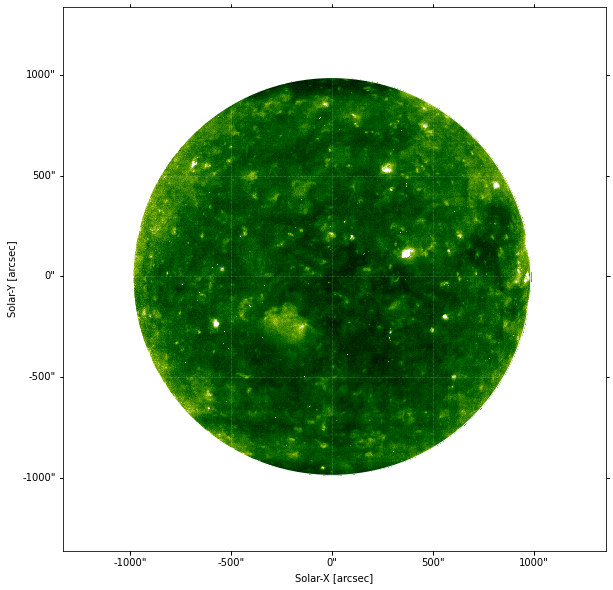

Observatory,SOHO
Instrument,EIT
Detector,EIT
Measurement,195.0 Angstrom
Wavelength,195.0 Angstrom
Observation Date,2008-01-01 00:00:09
Exposure Time,12.592000 s
Dimension,[1024. 1024.] pix
Coordinate System,helioprojective
Scale,[2.63 2.63] arcsec / pix
Reference Pixel,[506.45 516.25] pix

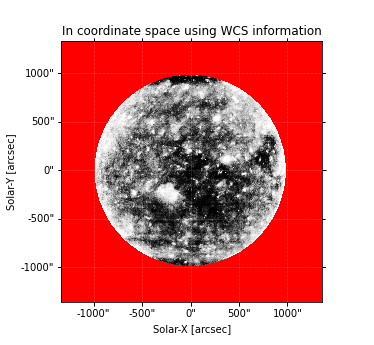
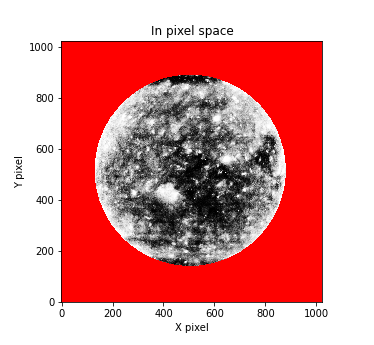
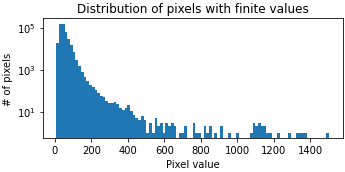

In [5]:
# Loop over all samples
for i in range(nb_files):

    # Corrections for EIT (per Michael Kirk)
    if eit_maps[0].observatory in ['SOHO']:
        new_coords = get_horizons_coord(eit_maps[i].observatory.replace(' ', '-'), eit_maps[i].date)
        eit_maps[i].meta['HGLN_OBS'] = new_coords.lon.to('deg').value
        eit_maps[i].meta['HGLT_OBS'] = new_coords.lat.to('deg').value
        eit_maps[i].meta['DSUN_OBS'] = new_coords.radius.to('m').value
        eit_maps[i].meta.pop('hec_x')
        eit_maps[i].meta.pop('hec_y')
        eit_maps[i].meta.pop('hec_z')

    # Find coordinates and radius
    hpc_coords = all_coordinates_from_map(eit_maps[i])
    r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / eit_maps[i].rsun_obs
    # Masking operation
    mask = ma.masked_greater_equal(r, 1)
    ma.set_fill_value(mask, np.nan)
    # Adjust data
    where_disk_eit = np.where(mask.mask == 1)
    eit_maps[i].data[where_disk_eit] = np.nan

# Plot disk image
palette = eit_maps[0].cmap
fig = plt.figure(figsize=(10, 10))
plt.subplot(projection=eit_maps[0])
eit_maps[0].plot(cmap=palette,vmin=-1,vmax=200)
eit_maps[0].draw_limb()
plt.show()

# Properties
eit_maps[0]

* __STEREO EUVI Data at 195 Å__

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much l

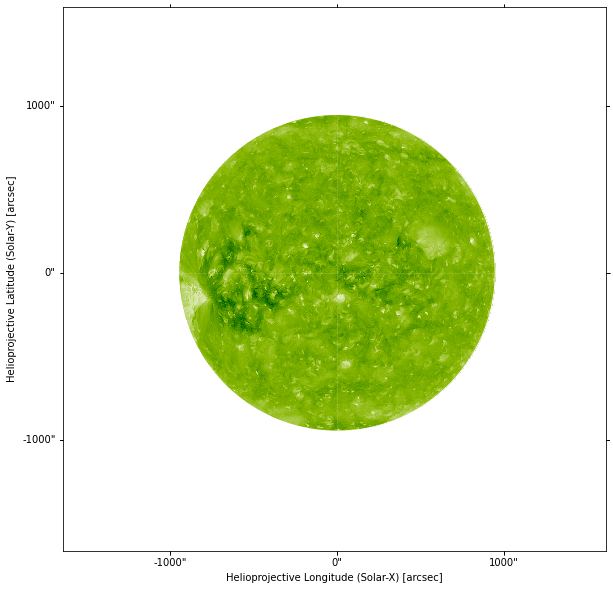

Observatory,STEREO B
Instrument,SECCHI
Detector,EUVI
Measurement,195.0 Angstrom
Wavelength,195.0 Angstrom
Observation Date,2008-01-01 00:15:52
Exposure Time,16.010800 s
Dimension,[2048. 2048.] pix
Coordinate System,helioprojective
Scale,[1.59 1.59] arcsec / pix
Reference Pixel,[1032.73 1046.83] pix

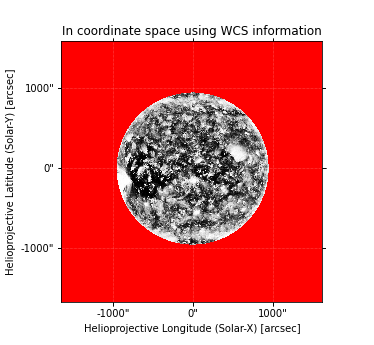
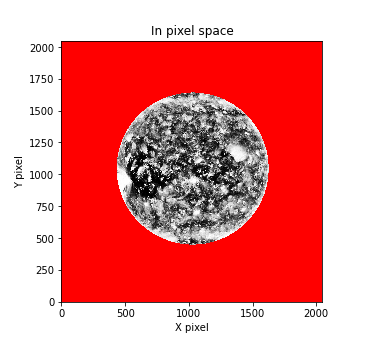
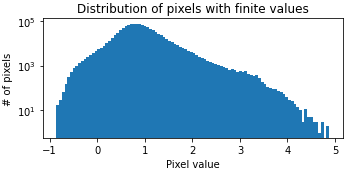

In [17]:
# Loop over all samples
for i in range(nb_files):
    # Find coordinates and radius
    hpc_coords = all_coordinates_from_map(euvil_maps[i])
    r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / euvil_maps[i].rsun_obs
    # Masking operation
    mask = ma.masked_greater_equal(r, 1)
    ma.set_fill_value(mask, np.nan)
    # Adjust data
    where_disk_euvi = np.where(mask.mask == 1)
    euvil_maps[i].data[where_disk_euvi] = np.nan

# Plot Disk Image
palette = euvil_maps[0].cmap
fig = plt.figure(figsize=(10, 10))
plt.subplot(projection=euvil_maps[0])
euvil_maps[0].plot(cmap=palette,vmin=-1,vmax=5)
euvil_maps[0].draw_limb()
plt.show()

# Properties
euvil_maps[0]

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much l

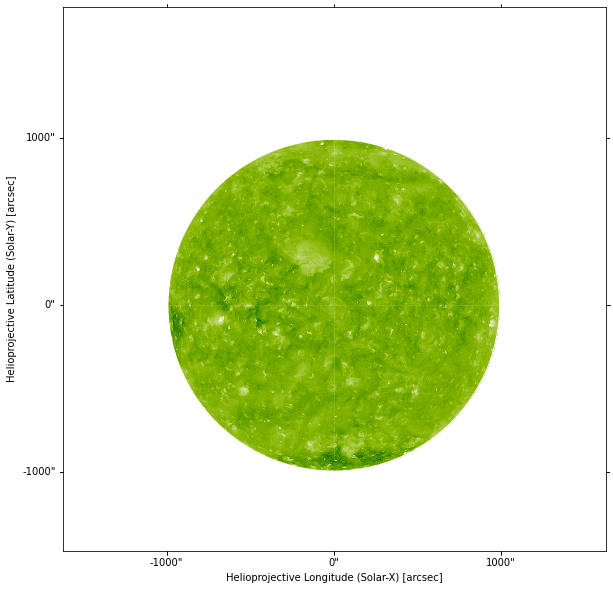

Observatory,STEREO A
Instrument,SECCHI
Detector,EUVI
Measurement,195.0 Angstrom
Wavelength,195.0 Angstrom
Observation Date,2008-01-01 00:05:30
Exposure Time,16.007400 s
Dimension,[2048. 2048.] pix
Coordinate System,helioprojective
Scale,[1.587774 1.587774] arcsec / pix
Reference Pixel,[1020.81 924.754] pix

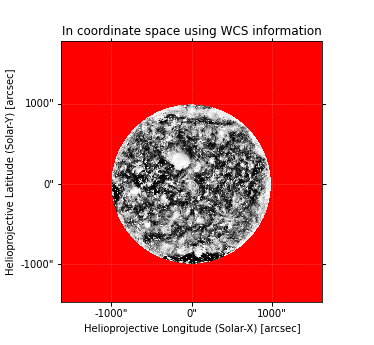
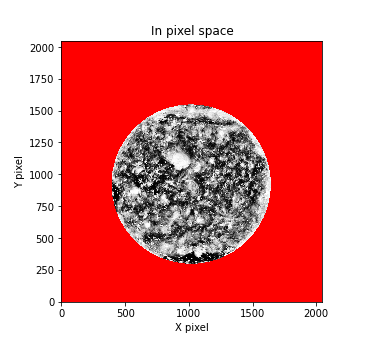
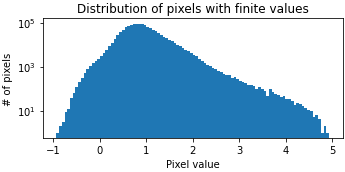

In [6]:
# Loop over all samples
for i in range(nb_files):
    # Find coordinates and radius
    hpc_coords = all_coordinates_from_map(euvir_maps[0])
    r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / euvir_maps[0].rsun_obs
    # Masking operation
    mask = ma.masked_greater_equal(r, 1)
    ma.set_fill_value(mask, np.nan)
    # Adjust data
    where_disk_euvi = np.where(mask.mask == 1)
    euvir_maps[i].data[where_disk_euvi] = np.nan

# Plot Disk Image
palette = euvir_maps[0].cmap
fig = plt.figure(figsize=(10, 10))
plt.subplot(projection=euvir_maps[0])
euvir_maps[0].plot(cmap=palette,vmin=-1,vmax=5)
euvir_maps[0].draw_limb()
plt.show()

# Properties
euvir_maps[0]

## Step 2: Wavelet Enhancement of EUV Images - Missing for SoHO EIT

Wavelet filtering is used to enhance the contrast in images and help more easily identify coronal holes.

_This step was already taken care of for the STEREO EUVI data, but not for SoHO/EIT._

## Step 3: Homogenization of EIT Through Histogram Matching

To homogenize EIT and EUVI data, we replicate the [_Hamada et al. (2019)_](https://link.springer.com/article/10.1007/s11207-019-1563-y)
process which consists of matching the cumulative histogram of EIT to the cumulative histogram of EUVI averaged over 90 timesteps.

_This process was performed ahead of time. Here we compare the cumulative histograms for validation._

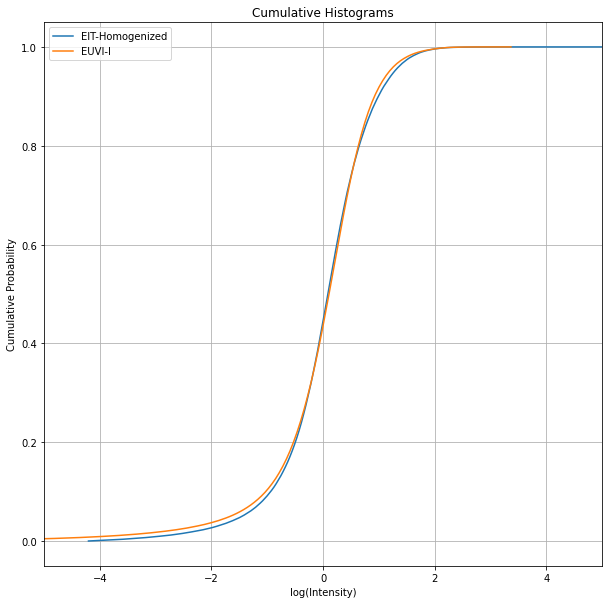

In [7]:
# Hamada class for homogenization
filename_cdfs = 'cumulative_hist.npz'
hamada_hist_matching = hamada(filename=filename_cdfs)

# Homogenization of the EIT data /w respect to EUVI
channel_nb = 0
for i in range(nb_files):
    arr_tmp = eit_maps[i].data
    where_disk = np.isfinite(arr_tmp)
    arr_tmp = hamada_hist_matching.hist_matching(arr_tmp, channel_nb)
    eit_maps[i].data[where_disk] = arr_tmp[where_disk]

# Load cumulative histograms of EUVI for comparison
npzfile = np.load('cumulative_hist.npz')
cdf_euvil = npzfile['cdf_euvil']
cdf_euvil = cdf_euvil[0, :]
bins_euvil = npzfile['bins_euvil']
x_euvil = bins_euvil[0, :]
bins_eit = npzfile['bins_eit']
x_eit = bins_eit[0, :]

# Compute histograms for EIT
log_eit = np.log10(eit_maps[1].data)
mean_log_eit = np.nanmean(log_eit)
std_log_eit = np.nanstd(log_eit)
norm_log_eit = (log_eit - mean_log_eit) / std_log_eit
hist, bins = np.histogram(norm_log_eit, bins=x_eit, density=True)
width = bins[1] - bins[0]
hist_eit = hist*width
cdf_eit = np.cumsum(hist_eit)

# Plot cumulative histograms
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
fig, ax = plt.subplots(figsize=(10, 10))
x = (x_eit[:-1] + x_eit[1:]) / 2
ax.plot(x, cdf_eit, c=colors[0], label='EIT-Homogenized')
x = (x_euvil[:-1] + x_euvil[1:]) / 2
ax.plot(x, cdf_euvil, c=colors[1], label='EUVI-l')
ax.grid(True)
ax.set_xlim(-5., 5.)
ax.set_title('Cumulative Histograms')
ax.set_xlabel('log(Intensity)')
ax.set_ylabel('Cumulative Probability')
ax.legend(loc='best', numpoints=1)
plt.draw()

## Step 4: Composite Maps

We now combine EIT and EUVI data.

Steps taken from the [Sunpy gallery](https://docs.sunpy.org/en/stable/generated/gallery/map_transformations/reprojection_aia_euvi_mosaic.html#sphx-glr-generated-gallery-map-transformations-reprojection-aia-euvi-mosaic-py).

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


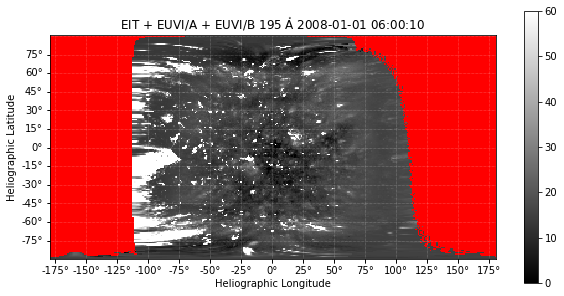

In [11]:
# We reproduce the Sunpy process (equal-area projection):
#
# Let's focus on a single timestep (can be looped)
timestep = 1
# We square the enhanced EUVI data to make it look closer to EIT.
# Weird, I know. It's to compensate the wavelet enhancement.
arr_tmp = euvil_maps[timestep].data
where_disk = np.isfinite(arr_tmp)
euvil_maps[timestep].data[where_disk] = arr_tmp[where_disk]**2
arr_tmp = euvir_maps[timestep].data
where_disk = np.isfinite(arr_tmp)
euvir_maps[timestep].data[where_disk] = arr_tmp[where_disk]**2
maps = [eit_maps[timestep], euvil_maps[timestep], euvir_maps[timestep]]

# Combined maps
shape_out = (180, 360)  # This is set deliberately low to reduce memory consumption
header = sunpy.map.make_fitswcs_header(shape_out,
                                       SkyCoord(0, 0, unit=u.deg,
                                       frame="heliographic_stonyhurst",
                                       obstime=maps[0].date),
                                       scale=[180 / shape_out[0],
                                              360 / shape_out[1]] * u.deg / u.pix,
                                       wavelength=int(maps[0].meta['wavelnth']) * u.AA,
                                       projection_code="CAR")
out_wcs = WCS(header)
coordinates = tuple(map(sunpy.map.all_coordinates_from_map, maps))
weights = [coord.transform_to("heliocentric").z.value for coord in coordinates]
weights = [(w / np.nanmax(w)) ** 3 for w in weights]
for w in weights:
    w[np.isnan(w)] = 0

array, _ = reproject_and_coadd(maps, out_wcs, shape_out,
                               input_weights=weights,
                               reproject_function=reproject_interp,
                               match_background=True,
                               background_reference=0)

# Final output
outmap = sunpy.map.Map((array, header))
# outmap.plot_settings = maps[1].plot_settings
outmap.nickname = 'EIT + EUVI/A + EUVI/B'

# Plot
plt.figure(figsize=(10, 5))
ax = plt.subplot(projection=out_wcs)
im = outmap.plot(vmin=0, vmax=60)
# im = outmap.plot()

# Position
lon, lat = ax.coords
lon.set_coord_type("longitude")
lon.coord_wrap = 180
lon.set_format_unit(u.deg)
lat.set_coord_type("latitude")
lat.set_format_unit(u.deg)
lon.set_axislabel('Heliographic Longitude', minpad=0.8)
lat.set_axislabel('Heliographic Latitude', minpad=0.9)
lon.set_ticks(spacing=25*u.deg, color='k')
lat.set_ticks(spacing=15*u.deg, color='k')

# Colorbar
plt.colorbar(im, ax=ax)

# Reset the view to pixel centers
_ = ax.axis((0, shape_out[1], 0, shape_out[0]))

# Show
plt.show()